# Turning Entity Linking into a Classification Problem

We're going to reformulate the entity linking problem into a classification problem. This Colab will show how to load the [BioCreative dataset](https://biocreative.bioinformatics.udel.edu/tasks/biocreative-viii/track-3/) along with the [Human Phenotype Ontology](https://hpo.jax.org/) and create a classification dataset. Below are illustrations of entity linking with the reformulation.

**Entity Linking:**

Given a mention of an entity (e.g. 'High arched palate'), which ontology term does it correspond to? (correct answer is HP:0000218).

**Entity Linking as Classification:**

Does this entity mention (e.g. 'High arched palate') correspond to this specific ontology term (e.g. HP:0000218)? Yes or No? (correct answer is Yes)



## Uploading the necessary files

The first thing to do is uploaded two of the files provided for the BioCreative track. Use the browse button below and select the files: `BioCreativeVIII3_TrainSet.tsv` and `UnobservableHPOTerms.tsv`.

In [ ]:
from google.colab import files
import os

expected_files = ['BioCreativeVIII3_TrainSet.tsv','UnobservableHPOTerms.tsv']
if not all( os.path.isfile(expected_file) for expected_file in expected_files ):
  uploaded = files.upload()
  for expected_file in expected_files:
    assert expected_file in uploaded.keys(), f"Expected upload of {expected_file}"

KeyboardInterrupt: ignored

## Loading the BioCreative training set

The code below loads the tab-delimited `BioCreativeVIII3_TrainSet.tsv` file and extracts the mentions along with their HPO terms. It also saves the location mentioned (the all-caps text at the beginning).

In [ ]:
import csv

dataset = []

with open('BioCreativeVIII3_TrainSet.tsv') as f:
  reader = csv.DictReader(f, delimiter='\t')
  for row in reader:
    if row['Spans'] == 'NA':
      continue

    text = row['Text']

    mention_text = []
    for span_section in row['Spans'].split(','):
      start,end = span_section.split('-')
      mention_text.append( text[int(start):int(end)] )
    mention_text = " ".join(mention_text)

    hpo_term = row['HPO Term']

    location = text[:text.index(':')].strip()

    dataset.append( {'mention':mention_text, 'location':location, 'hpo_term':hpo_term} )


Let's load it up in Pandas to see what we've got

In [ ]:
import pandas as pd

df = pd.DataFrame(dataset)
df

,mention,location,hpo_term
0,High arched palate,MOUTH,HP:0000218
1,little subcutaneous fat,EXTREMITIES,HP:0003758
2,gapt between toes 1 and 2,HANDS FEET,HP:0001852
3,toe 4 overlaps toe 5,HANDS FEET,HP:0001845
4,thin upper lip,MOUTH,HP:0000219
...,...,...,...
2557,3rd toe clinodactyly,HANDS FEET,HP:0008115
2558,Prominent eyes,EYES,HP:0000520
2559,Widely spaced teeth,MOUTH,HP:0000687
2560,drooling,MOUTH,HP:0002307


We'll also load up the provided unobservable HPO identifiers and save them. These are used to filter out HPO terms that should be ignored.

In [ ]:
unobservable = set()

with open('UnobservableHPOTerms.tsv') as f:
  reader = csv.DictReader(f, delimiter='\t')
  for row in reader:
    unobservable.add(row['ExcludedTerm'])

print(f"Loaded {len(unobservable)} unobservable HPO terms")

Loaded 5193 unobservable HPO terms


## Loading the Human Phenotype Ontology (HPO)

We'll need the names and definitions of terms from the [Human Phenotype Ontology](https://hpo.jax.org). We'll use the [pronto](https://github.com/althonos/pronto) Python library that is useful for processing ontologies. Let's install it

In [ ]:
!pip install pronto

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.2 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0


With pronto, we can load the HPO directly as below.

In [ ]:
import pronto
hpo = pronto.Ontology.from_obo_library("hp.obo")

/usr/local/lib/python3.10/dist-packages/pronto/ontology.py:206: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  return cls(


We can then access specific terms directly such as [HP:0008034](https://hpo.jax.org/app/browse/term/HP:0008034).

In [ ]:
term = hpo['HP:0008034']
term

Term('HP:0008034', name='Abnormal iris pigmentation')

From that term, we can get the ID, name and definition (and many other things). Note that you need the `str` around the definition to access it properly.

In [ ]:
print(f"{term.id=}")
print(f"{term.name=}")
print(f"{str(term.definition)=}")

term.id='HP:0008034'
term.name='Abnormal iris pigmentation'
str(term.definition)='Abnormal pigmentation of the iris.'


## List out the observable HPO terms

Now we can get a list of all possible HPO terms by taking the HPO and filtering out the unobservable ones that we loaded earlier.

In [ ]:
observable = set()

phenotype_abnormality_term = hpo['HP:0000118']
for hpo_term in phenotype_abnormality_term.subclasses():
  hpo_id = hpo_term.id
  if not hpo_id in unobservable:
    observable.add(hpo_id)

observable = sorted(observable)
print(f"Got {len(observable)} observable HPO terms")

Got 11939 observable HPO terms


## Creating a classification dataset

Now we've got the BioCreative dataset which contains all the right answers (mentions and their mapping to the correct HPO term). We want to create a dataset that contains some correct and some incorrect answers. The challenge would then be to predict which are correct and which are incorrect.

Let's create the dataset.

In [ ]:


import random
random.seed(42) # Set a random seed so that it is consistent

classification_dataset = []

for row in dataset: # Iterate through the dataset loaded from BioCreativeVIII3_TrainSet.tsv

  # Pull out the location and mention from the phenotype text
  location = row['location']
  mention = row['mention']

  # Get the correct answer and access the name & definition from the HPO
  correct_hpo_id = row['hpo_term']
  correct_hpo_name = hpo[correct_hpo_id].name  # pronto
  correct_hpo_definition = str(hpo[correct_hpo_id].definition) #pronto

  # Save the correct answer as a positive sample (with label=1)
  positive_sample = { 'label':1, 'location':location, 'mention':mention, 'hpo_id':correct_hpo_id, 'hpo_name':correct_hpo_name, 'hpo_definition':correct_hpo_definition}
  classification_dataset.append(positive_sample)

  # Create an incorrect answer by picking a random HPO term, then get its
  # name & definition from the HPO
  incorrect_hpo_id = random.choice(observable)
  incorrect_hpo_name = hpo[incorrect_hpo_id].name
  incorrect_hpo_definition = str(hpo[incorrect_hpo_id].definition)

  # Save the incorrect answer as a negative sample (with label=0)
  negative_sample = { 'label':0, 'location':location, 'mention':mention, 'hpo_id':incorrect_hpo_id, 'hpo_name':incorrect_hpo_name, 'hpo_definition':incorrect_hpo_definition}
  classification_dataset.append(negative_sample)



### Trying various approaches

In [ ]:
# for one sample

# !pip install python-Levenshtein
# !pip install fuzzywuzzy
# !pip install tensorflow
# !pip install scikit-learn

import tensorflow as tf
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Precompute similarities for all HPO terms
def compute_similarities(correct_hpo_id, hpo_terms):
    correct_name = hpo[correct_hpo_id].name

    # Calculate similarity for all HPO terms
    similarities = {incorrect_id: fuzz.ratio(correct_name, hpo[incorrect_id].name) for incorrect_id in hpo_terms}
    return similarities

# Find the most similar HPO term based on k-NN approximation
def get_most_similar_hpo_knn(correct_hpo_id, hpo_terms, k):
    correct_name = hpo[correct_hpo_id].name

    # Create a list of HPO names for all hpo_terms
    hpo_names = [hpo[id].name for id in hpo_terms]

    # Compute TF-IDF vectors for HPO names
    tfidf_vectorizer = TfidfVectorizer()
    hpo_tfidf = tfidf_vectorizer.fit_transform(hpo_names)

    # Use k-NN to find approximate nearest neighbors
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    knn.fit(hpo_tfidf)
    _, indices = knn.kneighbors(tfidf_vectorizer.transform([correct_name]))

    # Get the k-nearest HPO term indices
    nearest_indices = indices[0]

    # Find the most similar HPO term from the k-nearest candidates
    most_similar_id = hpo_terms[nearest_indices[0]]

    return most_similar_id

# Assuming you have defined 'dataset' and 'observable' and loaded them correctly
# Select one sample from the dataset
sample_index = 10
selected_sample = dataset[sample_index]

correct_hpo_id = selected_sample['hpo_term']
hpo_terms = [id for id in observable if id != correct_hpo_id]

# Set the number of approximate nearest neighbors to consider
k_neighbors = 100

# Get the most similar incorrect HPO term using k-NN approximation
incorrect_hpo_id = get_most_similar_hpo_knn(correct_hpo_id, hpo_terms, k_neighbors)

# Now you have the correct and incorrect HPO terms for the selected sample
correct_hpo_name = hpo[correct_hpo_id].name
incorrect_hpo_name = hpo[incorrect_hpo_id].name

print(f"Correct HPO: {correct_hpo_id} - {correct_hpo_name}")
print(f"Most similar incorrect HPO: {incorrect_hpo_id} - {incorrect_hpo_name}")

Correct HPO: HP:0001543 - Gastroschisis
Most similar incorrect HPO: HP:0034289 - Elevated circulating rT3/T3 ratio


In [ ]:
print(f"{location=}")
print(f"{mention=}")
print(f"{correct_hpo_id=}")
print(f"{correct_hpo_name=}")
print(f"{correct_hpo_definition=}")
print(f"{incorrect_hpo_id=}")
print(f"{incorrect_hpo_name=}")
print(f"{incorrect_hpo_definition=}")

location='MOUTH'
mention='Mouth is held open'
correct_hpo_id='HP:0000194'
correct_hpo_name='Open mouth'
correct_hpo_definition='A facial appearance characterized by a permanently or nearly permanently opened mouth.'
incorrect_hpo_id='HP:0030656'
incorrect_hpo_name='Umbilical vein varix'
incorrect_hpo_definition='Focal dilation of the umbilical vein.'


###Picking the negatives

In the above code, a random HPO term is picked completely randomly from all observable HPO as the negative sample. There is some nuance here as this create an "easy" challenge as a random HPO term will likely be dramatically different from the correct answer. A harder challenge would be to pick a negative HPO term that is relatively similar to the correct term. But let's stick with the completely random approach at the moment. This could be explored more!

### Examining the classification dataset

Let's load it into pandas to view the data.

Now the `label` column shows the target column which we are trying to predict. This dataset would need to be split into parts (e.g. training & validation). Whatever classification approach could then be evaluated using traditional classification metrics (e.g. accuracy, precision, recall, F1).

In [ ]:
classification_df = pd.DataFrame(classification_dataset)
classification_df.to_csv("/content/createdclassification.csv")

classification_df

,label,location,mention,hpo_id,hpo_name,hpo_definition
0,1,MOUTH,High arched palate,HP:0000218,High palate,Height of the palate more than 2 SD above the ...
1,0,MOUTH,High arched palate,HP:0002705,"High, narrow palate",The presence of a high and narrow palate.
2,1,EXTREMITIES,little subcutaneous fat,HP:0003758,Reduced subcutaneous adipose tissue,A reduced amount of fat tissue in the lowest l...
3,0,EXTREMITIES,little subcutaneous fat,HP:0009003,Increased subcutaneous truncal adipose tissue,The presence of an abnormally increased amount...
4,1,HANDS FEET,gapt between toes 1 and 2,HP:0001852,Sandal gap,A widely spaced gap between the first toe (the...
...,...,...,...,...,...,...
5119,0,MOUTH,Widely spaced teeth,HP:0006313,Widely spaced primary teeth,Increased space between the primary teeth. Not...
5120,1,MOUTH,drooling,HP:0002307,Drooling,Habitual flow of saliva out of the mouth.
5121,0,MOUTH,drooling,HP:0034289,Elevated circulating rT3/T3 ratio,An abnormally increased ratio of the concentra...
5122,1,MOUTH,Mouth is held open,HP:0000194,Open mouth,A facial appearance characterized by a permane...


Lastly, we can download this classification dataset with the code below.

In [ ]:
prompt = f"""
Does the text '{mention}' correspond with the description below? Answer only Yes or No.

{correct_hpo_name}: {correct_hpo_definition}
""".lstrip()

print(prompt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
n

In [ ]:
# !pip install python-Levenshtein
# !pip install fuzzywuzzy
# !pip install tensorflow
# !pip install scikit-learn

import random
import tensorflow as tf
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Precompute similarities for all HPO terms
def compute_similarities(correct_hpo_id, hpo_terms):
    correct_name = hpo[correct_hpo_id].name

    # Calculate similarity for all HPO terms
    similarities = {incorrect_id: fuzz.ratio(correct_name, hpo[incorrect_id].name) for incorrect_id in hpo_terms}
    return similarities

# Find the most similar HPO term based on k-NN approximation
def get_most_similar_hpo_knn(correct_hpo_id, hpo_terms, k):
    correct_name = hpo[correct_hpo_id].name

    # Create a list of HPO names for all hpo_terms
    hpo_names = [hpo[id].name for id in hpo_terms]

    # Compute TF-IDF vectors for HPO names
    tfidf_vectorizer = TfidfVectorizer()
    hpo_tfidf = tfidf_vectorizer.fit_transform(hpo_names)

    # Use k-NN to find approximate nearest neighbors
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    knn.fit(hpo_tfidf)
    _, indices = knn.kneighbors(tfidf_vectorizer.transform([correct_name]))

    # Get the k-nearest HPO term indices
    nearest_indices = indices[0]

    # Find the most similar HPO term from the k-nearest candidates
    most_similar_id = hpo_terms[nearest_indices[0]]

    return most_similar_id

# Assuming you have defined 'dataset' and 'observable' and loaded them correctly
# Select one sample from the dataset
sample_index = 1
selected_sample = dataset[sample_index]

correct_hpo_id = selected_sample['hpo_term']
hpo_terms = [id for id in observable if id != correct_hpo_id]

# Set the number of approximate nearest neighbors to consider
k_neighbors = 100

# Get the most similar incorrect HPO term using k-NN approximation
incorrect_hpo_id = get_most_similar_hpo_knn(correct_hpo_id, hpo_terms, k_neighbors)

# Now you have the correct and incorrect HPO terms for the selected sample
correct_hpo_name = hpo[correct_hpo_id].name
incorrect_hpo_name = hpo[incorrect_hpo_id].name

print(f"Correct HPO: {correct_hpo_id} - {correct_hpo_name}")
print(f"Most similar incorrect HPO: {incorrect_hpo_id} - {incorrect_hpo_name}")

# sir's code for random
random.seed(42) # Set a random seed so that it is consistent

classification_dataset = []
count = 0
for row in dataset: # Iterate through the dataset loaded from BioCreativeVIII3_TrainSet.tsv

    # Pull out the location and mention from the phenotype text
    location = row['location']
    mention = row['mention']

    # Get the correct answer and access the name & definition from the HPO
    correct_hpo_id = row['hpo_term']
    correct_hpo_name = hpo[correct_hpo_id].name  # pronto
    correct_hpo_definition = str(hpo[correct_hpo_id].definition) #pronto

    # Save the correct answer as a positive sample (with label=1)
    positive_sample = { 'label': 1, 'location': location, 'mention': mention, 'hpo_id': correct_hpo_id, 'hpo_name': correct_hpo_name, 'hpo_definition': correct_hpo_definition }
    classification_dataset.append(positive_sample)

    # Create an incorrect answer by using k-NN to get the most similar HPO term
    # and then get its name & definition from the HPO
    hpo_terms = [id for id in observable if id != correct_hpo_id]
    k_neighbors = 1  # Set the number of approximate nearest neighbors to consider
    incorrect_hpo_id = get_most_similar_hpo_knn(correct_hpo_id, hpo_terms, k_neighbors)
    incorrect_hpo_name = hpo[incorrect_hpo_id].name
    incorrect_hpo_definition = str(hpo[incorrect_hpo_id].definition)
    print(incorrect_hpo_name)
    print(count)
    count+=1

    # Save the incorrect answer as a negative sample (with label=0)
    negative_sample = { 'label': 0, 'location': location, 'mention': mention, 'hpo_id': incorrect_hpo_id, 'hpo_name': incorrect_hpo_name, 'hpo_definition': incorrect_hpo_definition }
    classification_dataset.append(negative_sample)

    # Do a little sanity check
    assert correct_hpo_id != incorrect_hpo_id  # Double check that the negative sample does not coincidentally match the positive sample


ModuleNotFoundError: ignored

# Multi-Prompt Test

In [ ]:
!pip install openai

prompts = [
    "Does the description associate with the mention?",
    "Is the provided mention accurately linked with the given description?",
    "Given the mention, check if the description is accurately defined",
    "Check if the mention matches with the description",
    "Can you check if the provided mention is congruent with the corresponding HPO database?",
    "Assessing the mention and its definition, can you verify the validity of their association in the context of human phenotypic variation."
]


In [ ]:
import pandas as pd

df = pd.read_csv('/content/createdclassification.csv')
#df_test = df[0:4]

df_test = df[0:50]

df_test

,label,location,mention,hpo_id,hpo_name,hpo_definition
0,1,MOUTH,High arched palate,HP:0000218,High palate,Height of the palate more than 2 SD above the ...
1,0,MOUTH,High arched palate,HP:0002705,"High, narrow palate",The presence of a high and narrow palate.
2,1,EXTREMITIES,little subcutaneous fat,HP:0003758,Reduced subcutaneous adipose tissue,A reduced amount of fat tissue in the lowest l...
3,0,EXTREMITIES,little subcutaneous fat,HP:0009003,Increased subcutaneous truncal adipose tissue,The presence of an abnormally increased amount...
4,1,HANDS FEET,gapt between toes 1 and 2,HP:0001852,Sandal gap,A widely spaced gap between the first toe (the...
5,0,HANDS FEET,gapt between toes 1 and 2,HP:0030280,Rib gap,Radiolucent focal defect of a rib shaft.
6,1,HANDS FEET,toe 4 overlaps toe 5,HP:0001845,Overlapping toe,Describes a foot digit resting on the dorsal s...
7,0,HANDS FEET,toe 4 overlaps toe 5,HP:0010557,Overlapping fingers,A finger resting on the dorsal surface of an a...
8,1,MOUTH,thin upper lip,HP:0000219,Thin upper lip vermilion,Height of the vermilion of the upper lip in th...
9,0,MOUTH,thin upper lip,HP:0010282,Thin lower lip vermilion,Height of the vermilion of the medial part of ...


### Strategy-1

Check if it returns 1/0: True/False and match with dataset and compute the accuracy.

1
Answer is: Yes
2
Answer is: Yes
3
Answer is: Yes
4
Answer is: No
5
Answer is: Yes
6
Answer is: No
7
Answer is: Yes
8
Answer is: No
9
Answer is: Yes
10
Answer is: Yes
11
Answer is: Yes
12
Answer is: No
13
Answer is: Yes
14
Answer is: No
15
Answer is: No
16
Answer is: No
17
Answer is: No
18
Answer is: No
19
Answer is: Yes
20
Answer is: No
21
Answer is: Yes
22
Answer is: No
23
Answer is: Yes
24
Answer is: No
25
Answer is: Yes
26
Answer is: Yes
27
Answer is: Yes
28
Answer is: Yes
29
Answer is: Yes
30
Answer is: No
31
Answer is: Yes
32
Answer is: No
33
Answer is: No
34
Answer is: No
35
Answer is: Yes
36
Answer is: Yes
37
Answer is: Yes
38
Answer is: Yes
39
Answer is: Yes
40
Answer is: No
41
Answer is: Yes
42
Answer is: No
43
Answer is: Yes
44
Answer is: Yes
45
Answer is: Yes
46
Answer is: Yes
47
Answer is: Yes
48
Answer is: No
49
Answer is: Yes
50
Answer is: Yes
51
Answer is: Yes
52
Answer is: Yes
53
Answer is: Yes
54
Answer is: No
55
Answer is: Yes
56
Answer is: No
57
Answer is: Yes
58
A

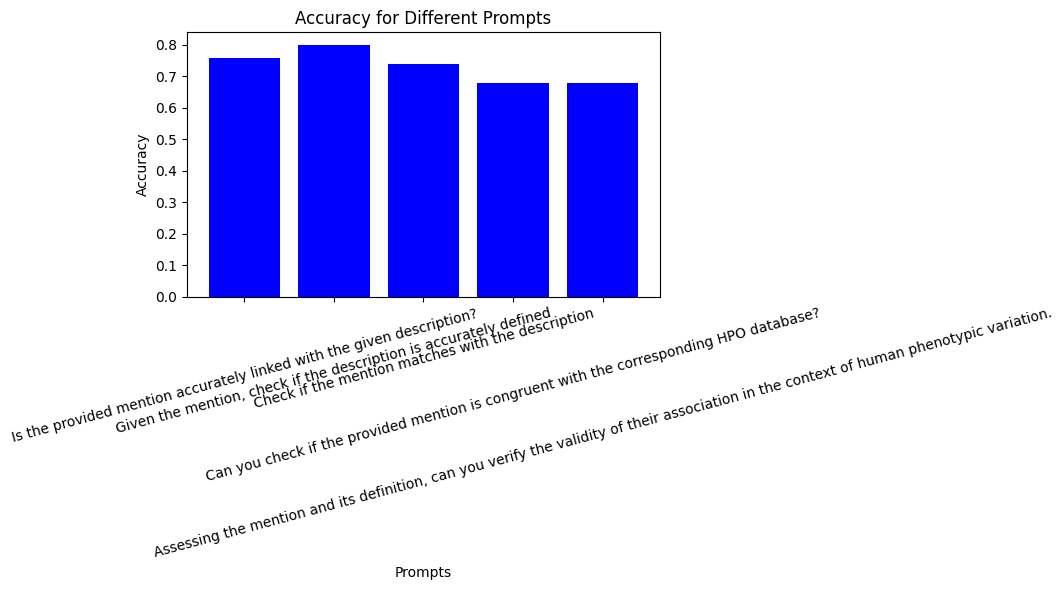

In [ ]:
#!pip install openai
import pandas as pd

df = pd.read_csv('/content/createdclassification.csv')
df_test = df[0:50]

import pandas as pd
import openai
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set up your OpenAI API key
openai.api_key = "Open_AI_key"

# Load your dataset into a DataFrame (replace 'your_data.csv' with your actual data file)
data = df_test
# Extract the features (X) and the target variable (y)
X = data[['location', 'mention', 'hpo_id', 'hpo_name', 'hpo_definition']]
y = data['label']

# Define the prompts
prompts = [
    "Is the provided mention accurately linked with the given description?",
    "Given the mention, check if the description is accurately defined",
    "Check if the mention matches with the description",
    "Can you check if the provided mention is congruent with the corresponding HPO database?",
    "Assessing the mention and its definition, can you verify the validity of their association in the context of human phenotypic variation.",
]

count = 0
predictions = {}

# Iterate over the prompts
for prompt in prompts:
    pred = []
    # Iterate through each row in the dataset
    for index, row in X.iterrows():
        mention = row['mention']
        description = row['hpo_definition']
        input_text = f"Mention of HPO term: {mention} \nDescription of HPO term: {description} \n{prompt} Answer in Yes/No."
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": input_text}],
            temperature=0,
        )
        answer = response.choices[0].message['content']
        count += 1
        print(count)
        print(f"Answer is: {answer}")
        answer = 1 if answer.lower() == 'yes' else 0
        pred.append(answer)
    predictions[prompt] = pred

# Calculate accuracy for each prompt separately
accuracy_results = {}
for prompt, pred in predictions.items():
    accuracy = accuracy_score(y, pred)
    accuracy_results[prompt] = accuracy
    print(f"Accuracy for '{prompt}': {accuracy}")


In [ ]:
import plotly.express as px

# Create a DataFrame for prompt data
prompt_df = pd.DataFrame({
    'Prompt': [f'Prompt {num}' for num in prompt_numbers],
    'Text': prompts,
    'Accuracy': accuracy_results.values()
})

# Create a bar chart using Plotly Express
fig = px.bar(
    prompt_df,
    x='Prompt',
    y='Accuracy',
    text='Text',
    color='Prompt',
    title='Accuracy for Different Prompts',
)

# Customize the layout
fig.update_layout(
    xaxis_title='Prompts',
    yaxis_title='Accuracy',
    xaxis=dict(tickangle=-45),
    uniformtext_minsize=8,
    uniformtext_mode='show',
)

# Save the chart as an HTML file
fig.write_html('accuracy_plot.html')

# Display the chart
fig.show()


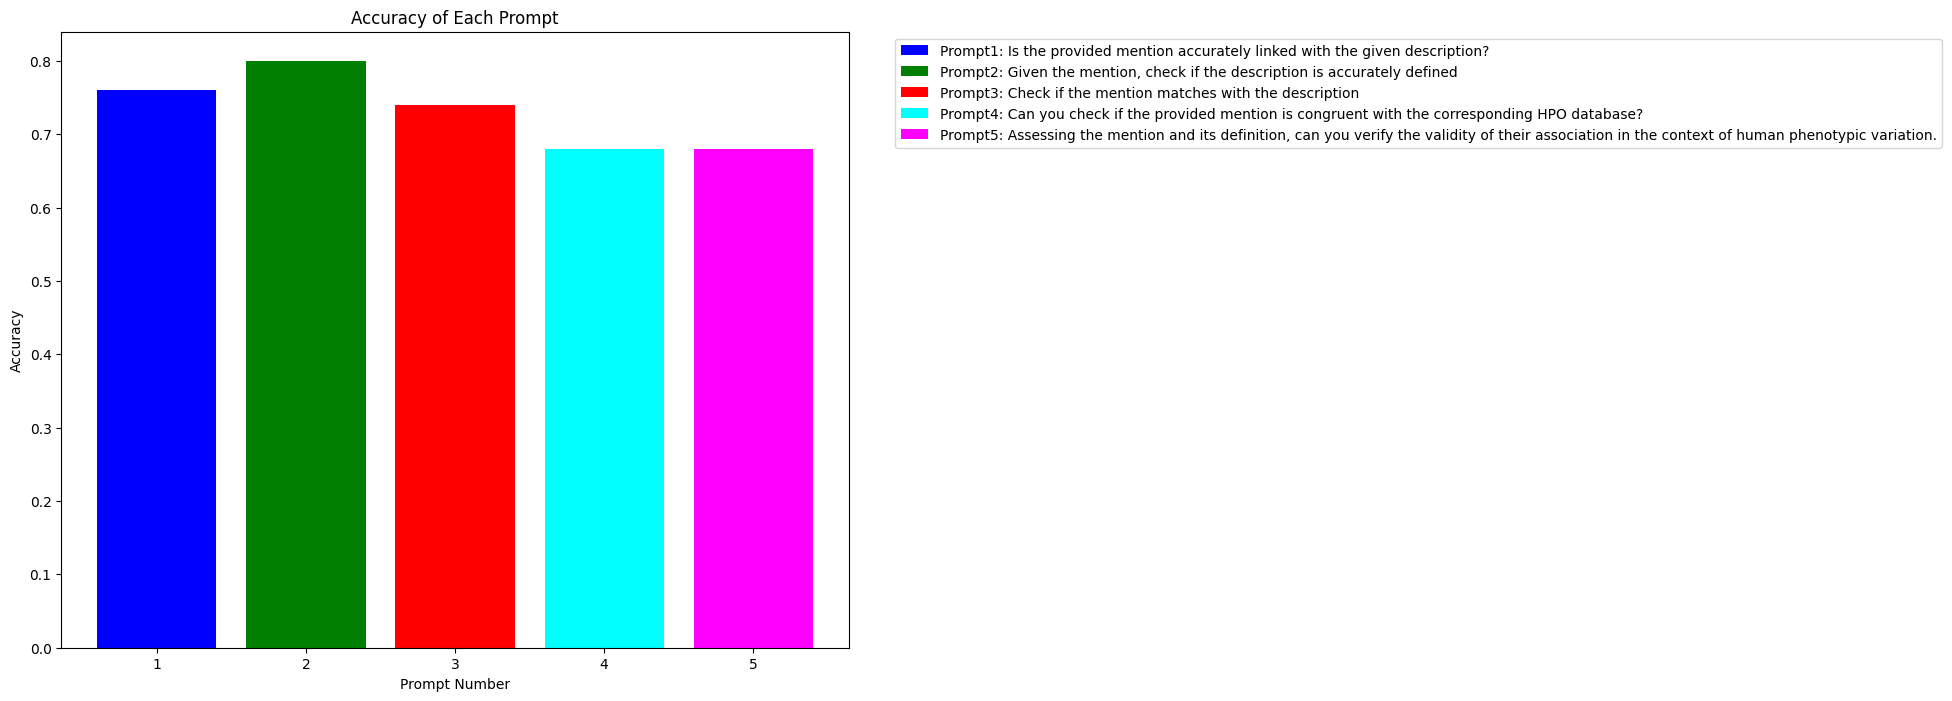

In [ ]:
import matplotlib.pyplot as plt

# Plotting the accuracy graph
plt.figure(figsize=(15, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

bars = plt.bar(range(len(accuracy_results)), list(accuracy_results.values()), align='center', color=colors)
plt.xticks(range(len(accuracy_results)), range(1, len(accuracy_results) + 1))

prompt_legend = [f"Prompt{index+1}: {prompt}" for index, prompt in enumerate(accuracy_results.keys())]
plt.legend(bars, prompt_legend, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Accuracy of Each Prompt')
plt.xlabel('Prompt Number')
plt.ylabel('Accuracy')

plt.subplots_adjust(right=0.65)
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
predictions

{'Is the provided mention accurately linked with the given description?': [1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1],
 'Given the mention, check if the description is accurately defined': [1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1],
 'Check if the mention matches with the description': [1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'Can you check if the provided mention is congruent

### Strategy-2

Ask the model to choose the correct HPO_ID from given 2 options. The two options are designed as tough choices using KNN.


In [ ]:
import pandas as pd
import openai
from sklearn.metrics import accuracy_score

# Set up your OpenAI API key
openai.api_key = "Open_AI_key"

# Load your dataset into a DataFrame (replace 'your_data.csv' with your actual data file)
data = df_test

# Split data into correct and incorrect sets
data_correct = data[data['label']==1]
data_incorrect = data[data['label']==0]
data_incorrect = data['hpo_id']

# Define the prompts
prompts = [
    "Given the mention and its description, select the correct HPO ID.",
    "Out of the given HPO IDs choose the correct HPO id for the given mention.",
    'Can you check which of the mentioned HPO id is correct for the mention?'
]

# Initialize a dictionary to store predictions for each prompt
predictions = {prompt: [] for prompt in prompts}

count= 0
# Iterate through each row in the correct data
for index, row in data_correct.iterrows():
    # Get the mention, description and correct HPO ID from the current row
    mention = row['mention']
    description = row['hpo_definition']
    correct_id = row['hpo_id']
    #print(correct_id)
    #print(index)

    # Get an incorrect HPO ID from the incorrect data
    incorrect_id = data_incorrect[index+1]
    #print(incorrect_id)
    #print("------")

    # Generate response for each prompt using GPT-3.5 Turbo
    for prompt in prompts:
        # Create the input text for GPT-3.5 Turbo
        input_text = f"Mention: {mention} \nDescription: {description} \nHPO ID-1: {correct_id} \nHPO ID-2: {incorrect_id} \n{prompt}. Just give as answer the exact HPO ID. No additional words."

        # Generate response from GPT-3.5 Turbo
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # Use GPT-3.5 Turbo
            messages = [{"role":"user","content":input_text}],
            temperature=0,  # Set the temperature to 0 for deterministic output
        )

        # Extract the 'choices' list from the response and get the 'text' field from it
        predicted_id = response.choices[0].message['content'].strip()
        print(count)
        print(predicted_id)
        count = count+2

        # Append to predictions whether predicted ID matches the correct ID
        predictions[prompt].append(predicted_id.lower() == correct_id.lower())

accuracies = []
# Calculate accuracy for each prompt
for prompt in prompts:
    accuracy = sum(predictions[prompt])/len(predictions[prompt])
    accuracies.append(accuracy)
    print(f"Accuracy for '{prompt}': {accuracy}")


0
HP:0000218
2
HP:0000218
4
HP:0000218
6
HP:0003758
8
HP:0003758
10
HP:0003758
12
HP:0001852
14
HP:0001852
16
HP:0001852
18
HP:0010557
20
HP:0010557
22
HP:0001845
24
HP:0000219
26
HP:0000219
28
HP:0000219
30
HP:0012740
32
HP:0012740
34
HP:0012740
36
HP:0000303
38
HP:0000303
40
HP:0000303
42
HP:0000316
44
HP:0034289
46
HP:0000316
48
HP:0001009
50
HP:0001009
52
HP:0001009
54
HP:0001100
56
HP:0001100
58
HP:0001100
60
HP:0001543
62
HP:0001543
64
HP:0001543
66
HP:0100699
68
HP:0100699
70
HP:0100699
72
HP:0008665
74
HP:0008665
76
HP:0008665
78
HP:0000368
80
HP:0000368
82
HP:0000369
84
HP:0100699
86
HP:0100699
88
HP:0100699
90
HP:0000341
92
HP:0000341
94
HP:0000341
96
HP:0030026
98
HP:0030026
100
HP:0030026
102
HP:0000369
104
HP:0000368
106
HP:0000369
108
HP:0100540
110
HP:0100540
112
HP:0100540
114
HP:0000494
116
HP:0000494
118
HP:0000494
120
HP:0000316
122
HP:0034289
124
HP:0000316
126
HP:0031364
128
HP:0031364
130
HP:0031364
132
HP:0012881
134
HP:0012881
136
HP:0012881
138
HP:0000311
140
H

In [ ]:
predictions

{'Given the mention and its description, select the correct HPO ID.': [True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True],
 'Out of the given HPO IDs choose the correct HPO id for the given mention.': [True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  True,
  False,
  True,
  True],
 'Can you check which of the mentioned HPO id is correct for the mention?': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True]}

In [ ]:
sum(predictions[prompt])

4

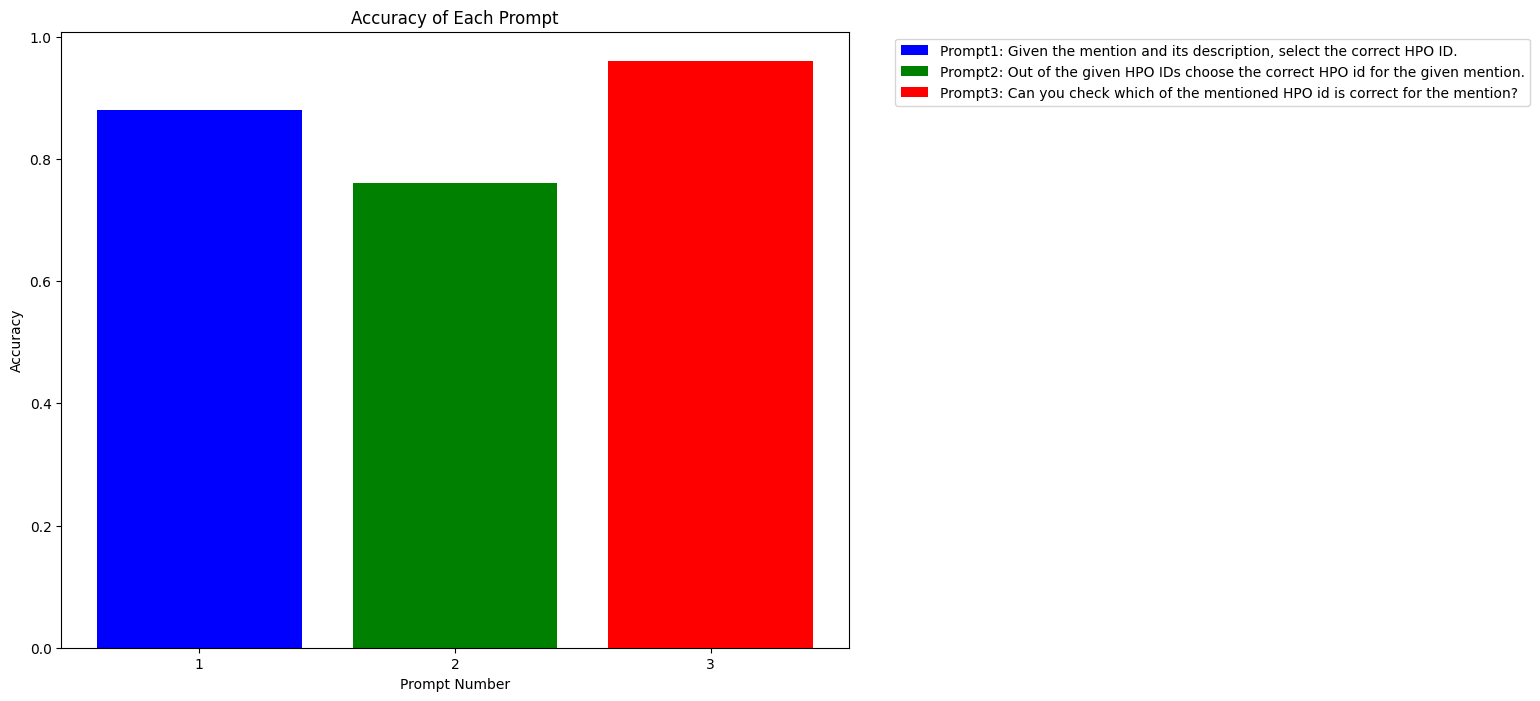

In [ ]:
# Plotting the accuracy graph
plt.figure(figsize=(15, 8))
colors = ['blue', 'green', 'red']

bars = plt.bar(range(len(accuracies)), accuracies, align='center', color=colors[:len(accuracies)])
plt.xticks(range(len(accuracies)), range(1, len(accuracies) + 1))

prompt_legend = [f"Prompt{index+1}: {prompt}" for index, prompt in enumerate(prompts)]
plt.legend(bars, prompt_legend, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Accuracy of Each Prompt')
plt.xlabel('Prompt Number')
plt.ylabel('Accuracy')

plt.subplots_adjust(right=0.65)
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')

plt.show()


### Strategy-3

Grouping multiple pairs of mention-description in single prompt and asking model to return Yes/No and checking for the same in DataFrame and computing accuracy,

In [ ]:
import pandas as pd
import openai
from sklearn.metrics import accuracy_score
import numpy as np
import re

# Set up your OpenAI API key
openai.api_key = "Open_AI_key"

# Load your dataset into a DataFrame (replace 'your_data.csv' with your actual data file)
data = df_test

# Define the prompts
prompts = [
    "For the following pairs of mention and description, please indicate with 'Yes' if they are accurately linked, and 'No' otherwise.",
    "From the given pairs of mention and description. Check which ones are correct and which ones aren't. Indicate with 'Yes' or 'No'.",
    "Here are the pairs of mention and description. Match them to see if they are correct or not.Indicate with 'Yes' or 'No'."
]

# Initialize a dictionary to store predictions for each prompt
predictions = {prompt: [] for prompt in prompts}

# Divide data into chunks of 50
chunks = [data[i:i + 50] for i in range(0, data.shape[0], 50)]
pattern = re.compile(r"\d+\.\s+(Yes|No)")

# Iterate over the chunks
for chunk in chunks:
    # Get the mention and description from the current chunk
    pairs = [f"Pair {i+1}: Mention: {row['mention']}, Description: {row['hpo_definition']}" for i, row in chunk.iterrows()]
    pairs_text = "\n".join(pairs)

    # Iterate over the prompts
    for prompt in prompts:
        # Create the input text for GPT-3.5 Turbo
        input_text = f"{pairs_text}\n{prompt}"

        # Generate response from GPT-3.5 Turbo
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # Use GPT-3.5 Turbo
            messages = [{"role":"user","content":input_text}],
            temperature=0,  # Set the temperature to 0 for deterministic output
        )

        # Extract the 'choices' list from the response and get the 'text' field from it
        answers_text = response.choices[0].message['content'].strip()
        print(answers_text)
        print("----")

        # Process the answers into a list
        answers = [1 if match.group(1) == 'Yes' else 0 for match in pattern.finditer(answers_text)]

        # Append answers to the predictions
        predictions[prompt].extend(answers)

accuracies = []
# Calculate accuracy for each prompt separately
for prompt, pred in predictions.items():
    accuracy = accuracy_score(data['label'], pred)
    accuracies.append(accuracy)
    print(f"Accuracy for '{prompt}': {accuracy}")


1. Yes
2. Yes
3. Yes
4. No
5. Yes
6. No
7. Yes
8. No
9. Yes
10. No
11. Yes
12. No
13. Yes
14. No
15. Yes
16. No
17. Yes
18. No
19. Yes
20. No
21. Yes
22. No
23. Yes
24. No
25. Yes
26. No
27. Yes
28. Yes
29. Yes
30. No
31. Yes
32. No
33. Yes
34. No
35. Yes
36. Yes
37. Yes
38. Yes
39. Yes
40. No
41. Yes
42. No
43. Yes
44. Yes
45. Yes
46. No
47. Yes
48. No
49. Yes
50. No
----
1. Yes
2. Yes
3. Yes
4. No
5. Yes
6. No
7. Yes
8. Yes
9. Yes
10. No
11. Yes
12. No
13. Yes
14. No
15. Yes
16. No
17. Yes
18. No
19. Yes
20. No
21. Yes
22. No
23. Yes
24. No
25. Yes
26. No
27. Yes
28. Yes
29. Yes
30. No
31. Yes
32. No
33. Yes
34. No
35. Yes
36. Yes
37. Yes
38. Yes
39. Yes
40. No
41. Yes
42. No
43. Yes
44. Yes
45. Yes
46. No
47. Yes
48. No
49. Yes
50. No
----
1. Yes
2. Yes
3. Yes
4. No
5. Yes
6. No
7. Yes
8. Yes
9. Yes
10. No
11. Yes
12. No
13. Yes
14. No
15. Yes
16. No
17. Yes
18. No
19. Yes
20. No
21. Yes
22. No
23. Yes
24. No
25. Yes
26. No
27. Yes
28. Yes
29. Yes
30. No
31. Yes
32. No
33. Yes
34. N

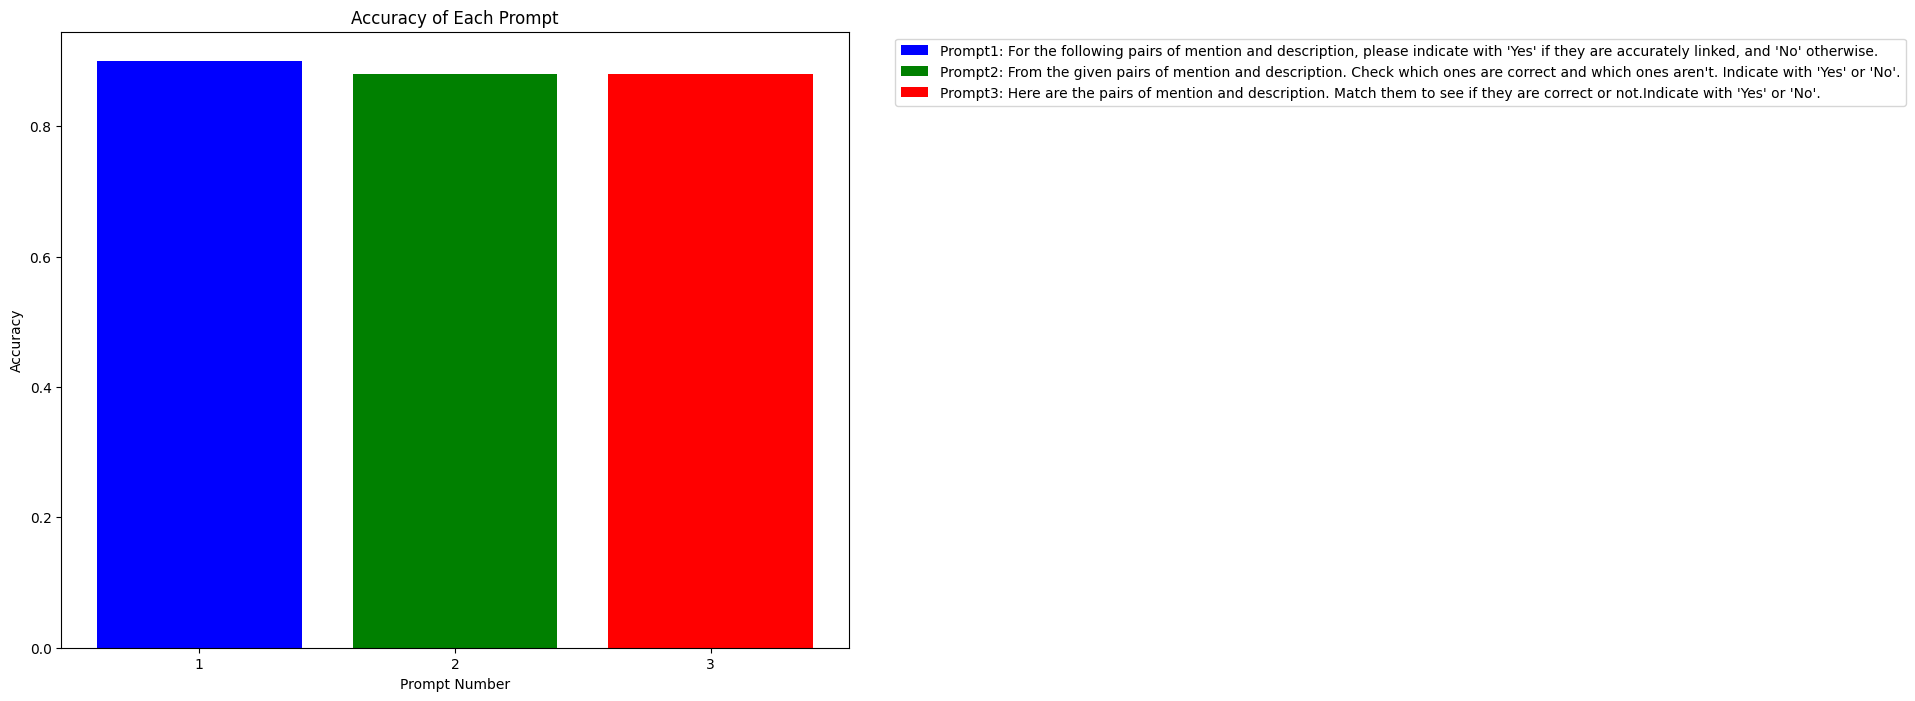

In [ ]:
# Plotting the accuracy graph
plt.figure(figsize=(15, 8))
colors = ['blue', 'green', 'red']

bars = plt.bar(range(len(accuracies)), accuracies, align='center', color=colors[:len(accuracies)])
plt.xticks(range(len(accuracies)), range(1, len(accuracies) + 1))

prompt_legend = [f"Prompt{index+1}: {prompt}" for index, prompt in enumerate(prompts)]
plt.legend(bars, prompt_legend, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Accuracy of Each Prompt')
plt.xlabel('Prompt Number')
plt.ylabel('Accuracy')

plt.subplots_adjust(right=0.65)
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
answers

[1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0]